In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0

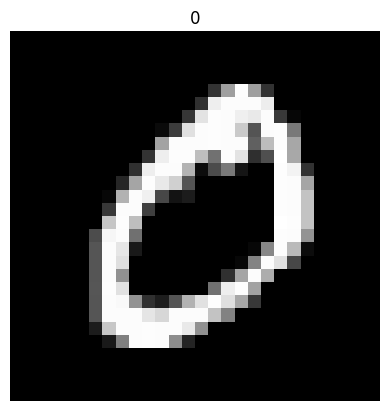

In [5]:
def draw(img, label):
  img = img.reshape((28, 28))
  plt.imshow(img, cmap='gray')
  plt.title(str(label))
  plt.axis('off')

draw(Xtrain[1], Ytrain[1])

In [6]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.features = torch.tensor(images, dtype=torch.float32).reshape(-1, 1, 28, 28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [7]:
train_dataset = CustomDataset(Xtrain, Ytrain)
test_dataset = CustomDataset(Xtest, Ytest)

In [8]:
len(train_dataset), len(test_dataset)

(60000, 10000)

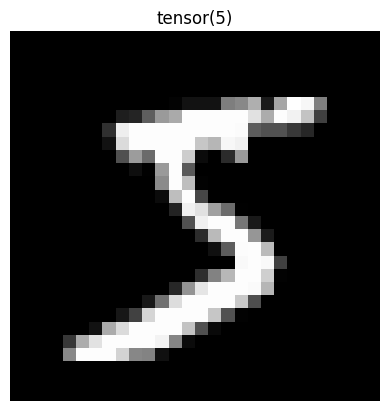

In [9]:
train_dataset[0]

draw(train_dataset[0][0], train_dataset[0][1])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [11]:
class MyNN(nn.Module):
  def __init__(self, input_channels):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1),

        nn.Linear(64 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(64, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

In [12]:
learning_rate = 0.01
epochs = 100

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
model = MyNN(1)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [15]:
!pip install torchinfo

from torchinfo import summary


summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNN                                     [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─BatchNorm2d: 2-3                  [32, 32, 28, 28]          64
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-5                       [32, 64, 14, 14]          18,496
│    └─ReLU: 2-6                         [32, 64, 14, 14]          --
│    └─BatchNorm2d: 2-7                  [32, 64, 14, 14]          128
│    └─MaxPool2d: 2-8                    [32, 64, 7, 7]            --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Flatten: 2-9                      [32, 3136]                --
│    └─Linear: 2-10                      [32, 128]                 401,536
│   

In [16]:
for epoch in range(epochs):
  total_epochs_loss = 0
  for batch_f, batch_l in train_loader:
    batch_f = batch_f.to(device)
    batch_l = batch_l.to(device)
    output = model(batch_f)
    loss = criterion(output, batch_l)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_epochs_loss += loss.item()
  accuracy = total_epochs_loss / len(train_loader)
  print(f'Epoch: {epoch + 1}, Loss: {accuracy}')

Epoch: 1, Loss: 0.2779638116632899
Epoch: 2, Loss: 0.07769861443166931
Epoch: 3, Loss: 0.05390608548509578
Epoch: 4, Loss: 0.04253862039175195
Epoch: 5, Loss: 0.03302172332795647
Epoch: 6, Loss: 0.02928303214671711
Epoch: 7, Loss: 0.024322287916531786
Epoch: 8, Loss: 0.019797438867456125
Epoch: 9, Loss: 0.016116511450040463
Epoch: 10, Loss: 0.01665999336548848
Epoch: 11, Loss: 0.013561702895585526
Epoch: 12, Loss: 0.01229843321131193
Epoch: 13, Loss: 0.011282957262219862
Epoch: 14, Loss: 0.009866440173780817
Epoch: 15, Loss: 0.007560825076812762
Epoch: 16, Loss: 0.007311091368750204
Epoch: 17, Loss: 0.007157499043490679
Epoch: 18, Loss: 0.006623887710475537
Epoch: 19, Loss: 0.00633690794401385
Epoch: 20, Loss: 0.005402002290417538
Epoch: 21, Loss: 0.004813447017796231
Epoch: 22, Loss: 0.004887252752413769
Epoch: 23, Loss: 0.003958275664063452
Epoch: 24, Loss: 0.004038835630046136
Epoch: 25, Loss: 0.003196830302251692
Epoch: 26, Loss: 0.003186358790279822
Epoch: 27, Loss: 0.004006753158

In [19]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
total = 0
correct = 0

with torch.no_grad():
  for batch_f, batch_l in test_loader:
    batch_f = batch_f.to(device)
    batch_l = batch_l.to(device)
    output = model(batch_f)
    _, pred = torch.max(output, 1)
    total += batch_l.shape[0]
    correct += (pred == batch_l).sum().item()

print(f'Accuracy: {correct / total}')

Accuracy: 0.9941


In [24]:
total = 0
correct = 0

with torch.no_grad():
  for batch_f, batch_l in train_loader:
    batch_f = batch_f.to(device)
    batch_l = batch_l.to(device)
    output = model(batch_f)
    _, pred = torch.max(output, 1)
    total += batch_l.shape[0]
    correct += (pred == batch_l).sum().item()

print(f'Accuracy: {correct / total}')

Accuracy: 1.0
